<a href="https://colab.research.google.com/github/uasimi/AlgoTrading/blob/main/p2_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 35.7 MB/s 
     |████████████████████████████████| 63 kB 976 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [17]:
import pandas as pd
import numpy as np
import yfinance as yf 
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib 
import pandas_datareader.data as web

In [18]:
btc_data = yf.download('BTC-USD', start='2017-01-01', end='2022-01-01')
# btc_df = pd.DataFrame(btc_data)

[*********************100%***********************]  1 of 1 completed


In [19]:
btc_df = pd.DataFrame(btc_data)

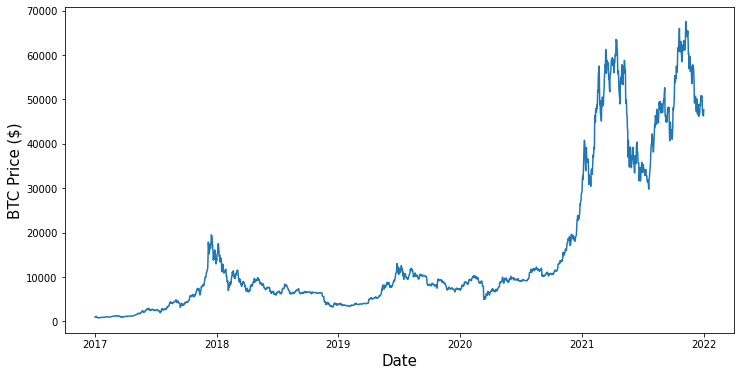

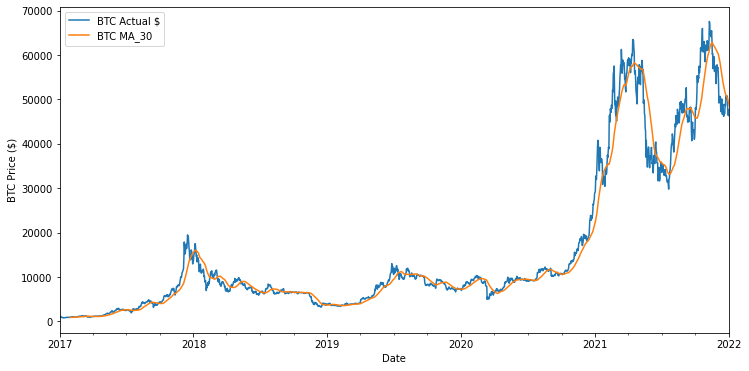

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(btc_df["Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('BTC Price ($)',fontsize=15)
plt.show()


# Rolling mean
close_px = btc_df['Close']
mavg = close_px.rolling(window=30).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='BTC Actual $')
mavg.plot(label='BTC MA_30')
plt.xlabel('Date')
plt.ylabel('BTC Price ($)')
plt.legend()

In [6]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = btc_df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,738152.0,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883
1823,738153.0,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299
1824,738154.0,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018
1825,738155.0,47169.371094,48472.527344,45819.953125,46306.445312,46306.445312,36974172400
1826,738156.0,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004


In [7]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
prices = np.array(btc_df['Close'])
prices = np.reshape(prices, (-1, 1))
# Fit the MinMaxScaler object with the features data X
scaler.fit(prices)
prices = scaler.transform(prices)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


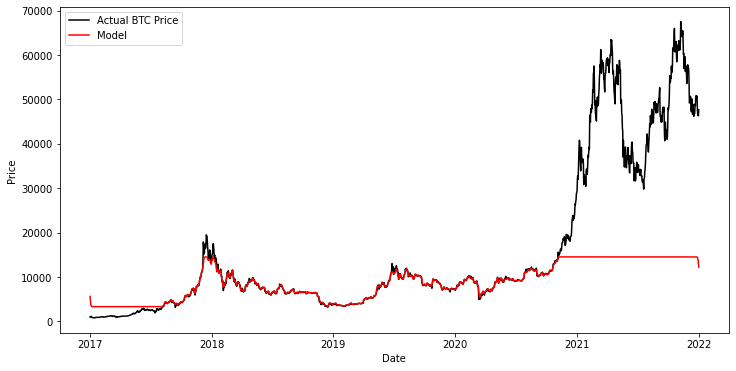

In [22]:
from sklearn.svm import SVR
from sklearn import svm
# import pandas_datareader.data as web
svr_model = svm.SVR()
#dates_df = pd.Series(dates_df['Date'])
#btc_df = pd.Series(btc_df['Close'])

##dates = dates_df['Date'].as_matrix()
#prices = btc_df['Close'].as_matrix()

# df = pd.DataFrame(columns=[dates_df['Date'],btc_df['Close']])

dates = np.array(dates_df['Date'])
prices = np.array(btc_df['Close'])

# Convert to 1d Vector
dates = np.reshape(dates, (-1, 1)) #len(dates) as -1
prices = np.reshape(prices, (-1, 1)) #len(prices) as -1

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices) 




plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Actual BTC Price')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'Model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Create train set of adj close prices data:
#train_data = btc_df.loc[:,'Close'].as_matrix()
train_data = prices
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1827, 1)


In [10]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1791, 36, 1)
X_train:
[[ 998.32501221]
 [1021.75      ]
 [1043.83996582]
 [1154.72998047]
 [1013.38000488]
 [ 902.20098877]
 [ 908.58502197]
 [ 911.19897461]
 [ 902.82800293]
 [ 907.67901611]
 [ 777.75701904]
 [ 804.83398438]
 [ 823.98400879]
 [ 818.4119873 ]
 [ 821.79797363]
 [ 831.53399658]
 [ 907.93798828]
 [ 886.61798096]
 [ 899.07299805]
 [ 895.02600098]
 [ 921.78900146]
 [ 924.67297363]
 [ 921.01202393]
 [ 892.68701172]
 [ 901.54199219]
 [ 917.58599854]
 [ 919.75      ]
 [ 921.59002686]
 [ 919.49597168]
 [ 920.38201904]
 [ 970.40301514]
 [ 989.02301025]
 [1011.79998779]
 [1029.91003418]
 [1042.90002441]
 [1027.33996582]]


y_train: [[1038.15002441]]



In [11]:
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
126/126 [==============================] - 11s 53ms/step - loss: 5.1354e-04 - val_loss: 0.0064
Epoch 2/20
126/126 [==============================] - 6s 46ms/step - loss: 2.0721e-04 - val_loss: 0.0055
Epoch 3/20
126/126 [==============================] - 6s 44ms/step - loss: 1.7233e-04 - val_loss: 0.0054
Epoch 4/20
126/126 [==============================] - 6s 44ms/step - loss: 1.6181e-04 - val_loss: 0.0023
Epoch 5/20
126/126 [==============================] - 7s 59ms/step - loss: 1.3952e-04 - val_loss: 0.0052
Epoch 6/20
126/126 [==============================] - 6s 45ms/step - loss: 1.3303e-04 - val_loss: 0.0027
Epoch 7/20
126/126 [==============================] - 6s 45ms/step - loss: 1.3456e-04 - val_loss: 0.0036
Epoch 8/20
126/126 [==============================] - 6s 45ms/step - loss: 1.1461e-04 - val_loss: 0.0033
Epoch 9/20
126/126 [==============================] - 6s 45ms/step - loss: 1.0889e-04 - val_loss: 0.0063
Epoch 10/20
126/126 [==============================] -

In [12]:
model.evaluate(X_train, y_train)

56/56 [==============================] - 1s 19ms/step - loss: 0.0021


0.0021406300365924835

In [13]:
predicted = model.predict(X_train)

In [14]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

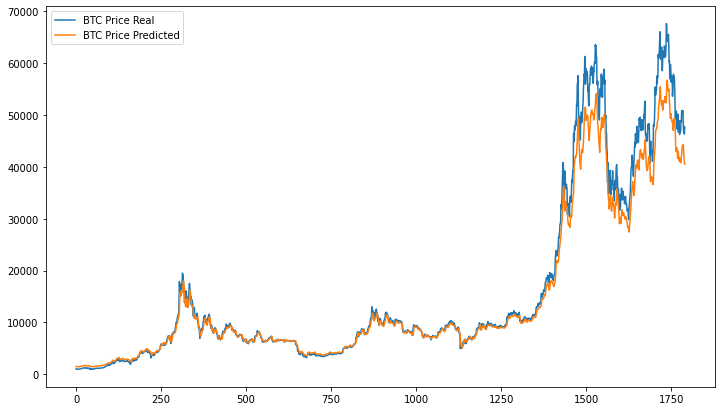

In [16]:
stocks = pd.DataFrame({
    'BTC Price Real': real_prices.ravel(),
    'BTC Price Predicted': predicted_prices.ravel()},
)
stocks.head()


stocks.plot(figsize=(12,7))